In [10]:
from pyDOE import lhs
#We will use Latin Hypercube Sampling from this library

In [11]:
import torch                           # Pytorch
import torch.autograd as autograd      # computation graph
from torch import Tensor
import torch.nn as nn                  # neural networks
import torch.optim as optim            # optimizers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import time, sys
from tqdm.notebook import tqdm_notebook

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("The neural network will be trainied on",device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

The neural network will be trainied on cuda


In [12]:
def plot3D(x,t,y):
    x_plot =x.squeeze(1)
    t_plot =t.squeeze(1)
    X,T= torch.meshgrid(x_plot,t_plot,indexing='ij')
    u_xt = y
    fig = plt.figure()
    ax=fig.subplots(1,1)
    cp = ax.contourf(T,X,u_xt,20,cmap=cm.rainbow) #)levels = np.linspace(-1.0,1.0,12))
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('u')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(T.detach().cpu().numpy(), X.detach().cpu().numpy(), u_xt.detach().cpu().numpy(),cmap=cm.rainbow, antialiased=False)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u')
    #ax.set_zlim3d(-1, 1)
    plt.show()


$ f = u_t ​− \alpha * u_{xx​} $

In [13]:
# x ∈ [0,2]
x_min = 0
x_max = 2

# t ∈ [0,0.48]
t_min = 0
t_max = 0.48

alpha = 0.01/np.pi  # Thermal diffusivity 


# Discretization points for x and t
total_points_x = 1001
total_points_t = 1000

dx = (x_max - x_min) / (total_points_x - 1)
dt = (t_max - t_min) / (total_points_t)

dx, dt, dt/dt


(0.002, 0.00047999999999999996, 1.0)

In [14]:
#Implementing Finite Difference Method to solve the 1D Diffusion Equation

def u_fdm_heat(x,t):
    un = torch.ones(total_points_x)
    rec = torch.zeros([total_points_x, total_points_t])

    for j in tqdm_notebook(range(total_points_t)):

        un = u.clone()

        for i in range(1,total_points_x-1):
            rec[i,j] = u[i]
            u[i] = un[i] + alpha * (dt/dx**2) * (un[i+1]- 2*un[i] + un[i-1])
            if np.isnan(u[i]):
              print(i, j, u[i-1])
              break

    return u, rec

In [15]:
x = torch.linspace(x_min, x_max, total_points_x)
u = torch.from_numpy(np.sin(np.pi*x.numpy()))

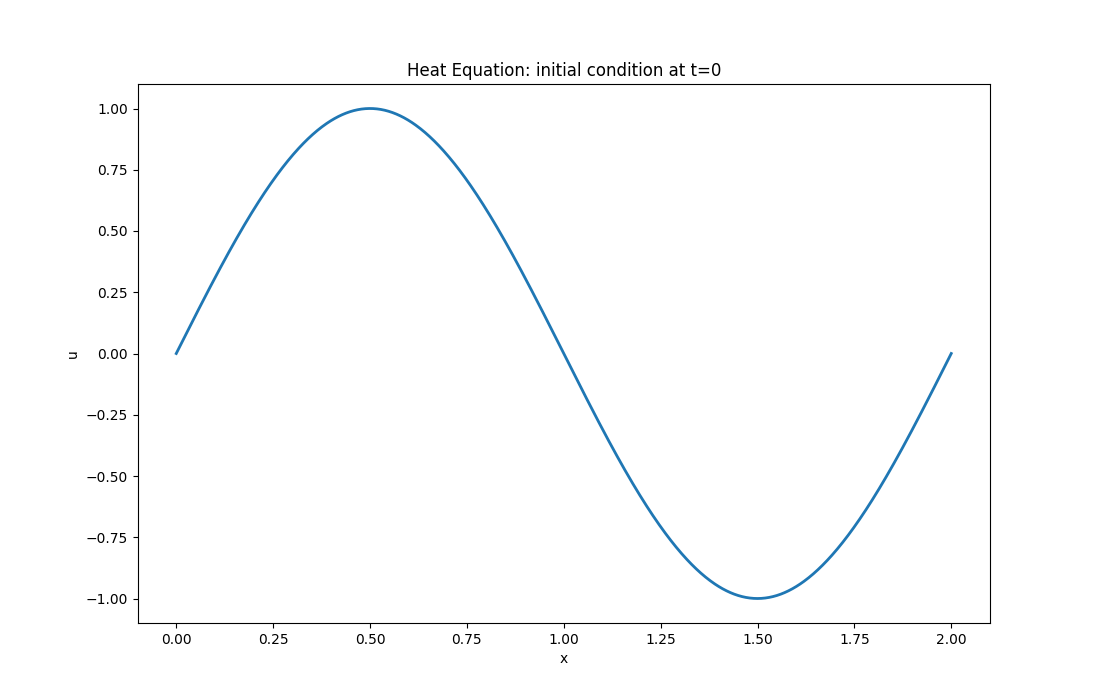

In [16]:
u_plot = u.clone()
plt.figure(figsize=(11, 7), dpi=100)
plt.plot(x, u_plot, lw=2)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Heat Equation: initial condition at t=0')
plt.show()

In [17]:
# Creating same amount of grid lattice as FDM

x = torch.linspace(x_min, x_max, total_points_x).view(-1,1)
t = torch.linspace(t_min, t_max, total_points_t).view(-1,1)
x.shape, t.shape

(torch.Size([1001, 1]), torch.Size([1000, 1]))

In [18]:
# Computing Finite Difference solution for u

print("Running Finite Difference Method...")
u_final, u_fdm_2D = u_fdm_heat(x,t)

assert u_fdm_2D.shape == torch.Size([total_points_x, total_points_t]),f"Expected [{total_points_x},{total_points_t}], got {u_fdm_2D.shape}"
print("Completed successfully!")

Running Finite Difference Method...


  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_73656/880144829.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  if np.isnan(u[i]):


Completed successfully!


In [19]:
X, T = torch.meshgrid(x.squeeze(1),t.squeeze(1), indexing='ij')

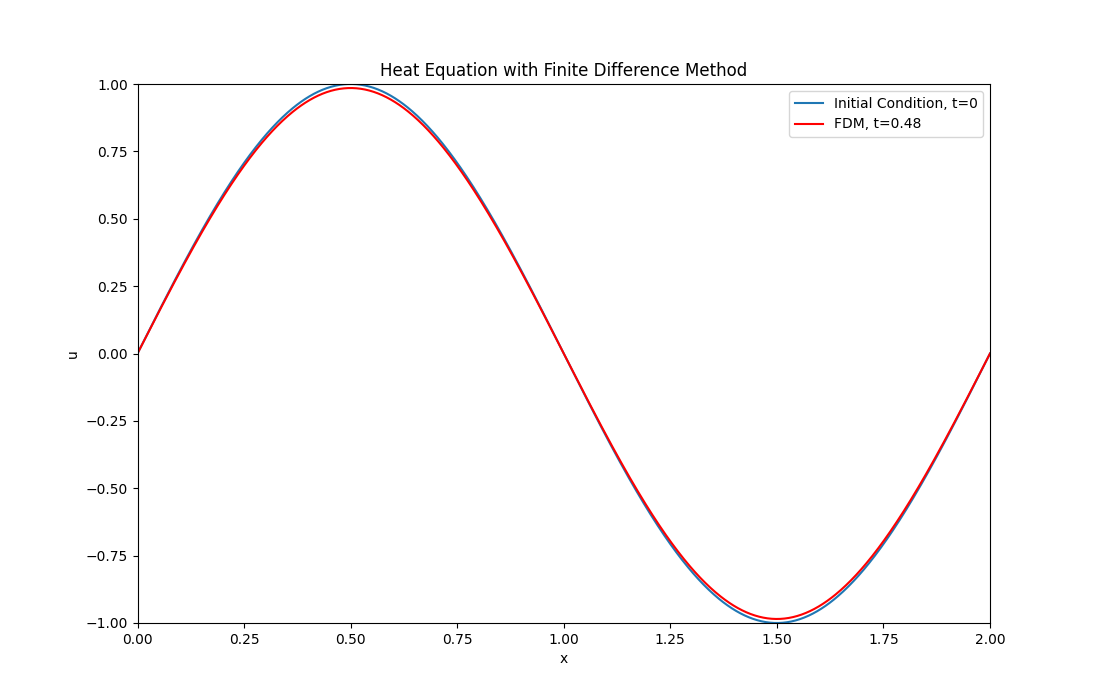

In [20]:
plt.figure(figsize=(11, 7), dpi= 100)
plt.plot(x, u_plot, label="Initial Condition, t=0")
plt.plot(x, u_final, 'r',label="FDM, t=0.48")
plt.xlim([x_min,x_max])
plt.ylim([-1, 1])
plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.title('Heat Equation with Finite Difference Method');
plt.show()

FDM Solution Visualization


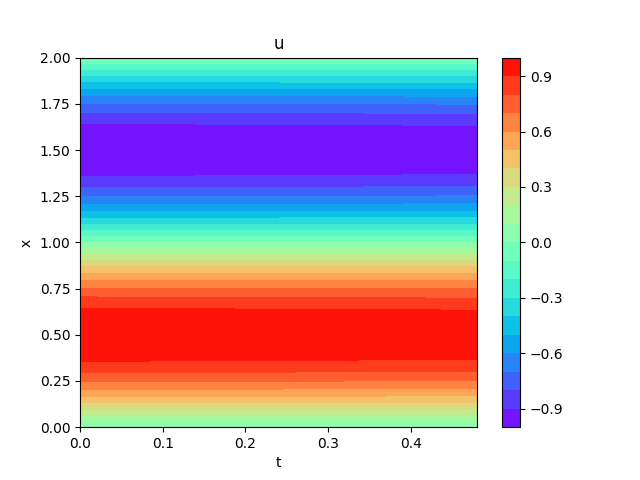

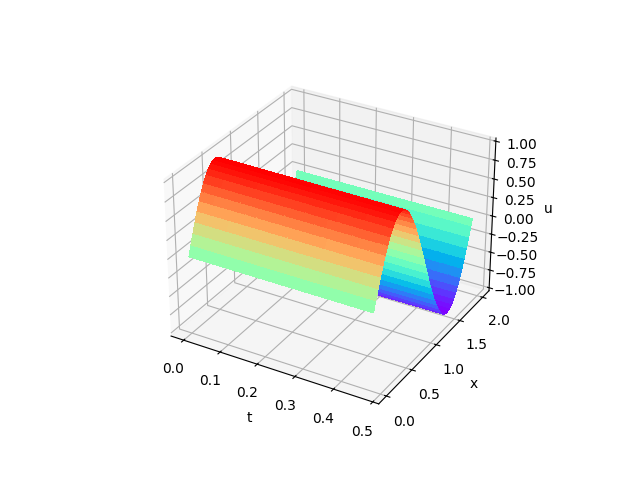

In [21]:
print("FDM Solution Visualization")
plot3D(x,t,u_fdm_2D)

In [22]:
X, T = torch.meshgrid(x.squeeze(1),t.squeeze(1), indexing='ij') #same as FDM
X.shape, T.shape

(torch.Size([1001, 1000]), torch.Size([1001, 1000]))

In [23]:
left_X = torch.hstack((X[:,0][:,None], T[:,0][:,None])) #horizontal stacking to create X, T dataset

In [24]:
left_U = torch.sin(np.pi*left_X[:,0]).unsqueeze(1) #initial condition is a sine wave
left_U.shape

torch.Size([1001, 1])

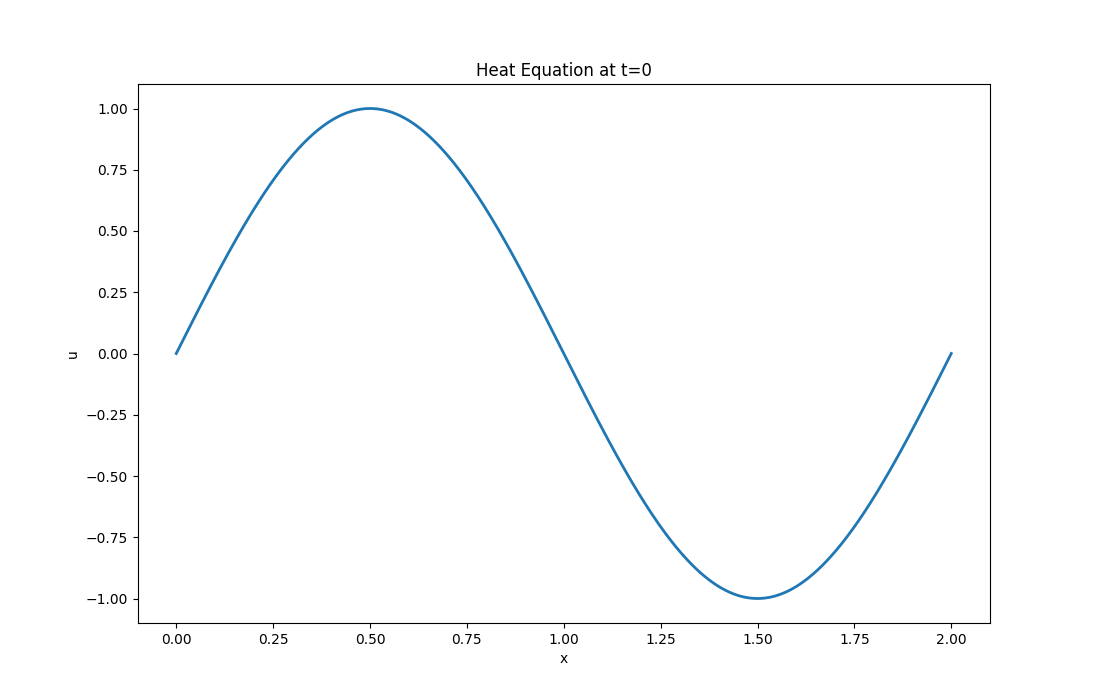

In [25]:
plt.figure(figsize=(11, 7), dpi= 100)
plt.plot(x, left_U, lw=2)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Heat Equation at t=0');

In [26]:
# BC at x_min
bottom_X = torch.hstack((X[0,:][:,None],T[0,:][:,None]))
top_X = torch.hstack((X[-1,:][:,None],T[-1,:][:,None]))

bottom_U = torch.zeros(bottom_X.shape[0],1)
top_U = torch.zeros(top_X.shape[0],1)

bottom_X.shape

torch.Size([1000, 2])

In [27]:
X_bc = torch.vstack([bottom_X, top_X])
U_bc = torch.vstack([bottom_U, top_U])

X_bc.shape

torch.Size([2000, 2])

In [28]:
N_ic = 1000
N_bc = 1000 #Number of points on IC and BC
N_pde = 30000 #Number of points on PDE domain (Collocation Points)

#Now we will sample N_bc points at random
#from the X_train, U_train dataset

idx = np.random.choice(X_bc.shape[0],N_bc, replace=False)
X_bc_samples = X_bc[idx,:]
U_bc_samples = U_bc[idx,:]

idx = np.random.choice(left_X.shape[0],N_ic, replace=False)
X_ic_samples = left_X[idx,:]
U_ic_samples = left_U[idx,:]

#The boundary conditions will not change.
#Hence, these U values can be used as supervised labels during training

#For PDE collocation points, we will generate new X_train_pde dataset
#We do not know U(X,T) for these points

#Lets get the entire X,T dataset in a format suitable for Neural Network
#We will later use this for testing NN as well. So, lets call this x_test for convenience

x_test = torch.hstack((X.transpose(1,0).flatten()[:,None],
                       T.transpose(1,0).flatten()[:,None]))

#We need column major flattening to simlulte time-marching. Hence the transpose(1,0) or simply use .T

#we will use U generated from FDM as our u_test
#We will use u_test later in the process for calculating NN performance

u_test = u_fdm_2D.transpose(1,0).flatten()[:,None]
x_test.shape

torch.Size([1001000, 2])

In [29]:
x_test.shape

torch.Size([1001000, 2])

In [30]:
#lower and upper bounds of x_test
lb = x_test[0]
ub = x_test[-1]
lb,ub

(tensor([0., 0.]), tensor([2.0000, 0.4800]))

In [31]:
#Sampling (X,T) domain using LHS
lhs_samples = lhs(2,N_pde)
#2 since there are 2 variables in X_train, [x,t]
lhs_samples.shape


(30000, 2)

In [32]:
X_train_lhs = lb + (ub-lb)*lhs_samples
X_train_lhs.shape


/tmp/ipykernel_73656/752805534.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X_train_lhs = lb + (ub-lb)*lhs_samples


torch.Size([30000, 2])

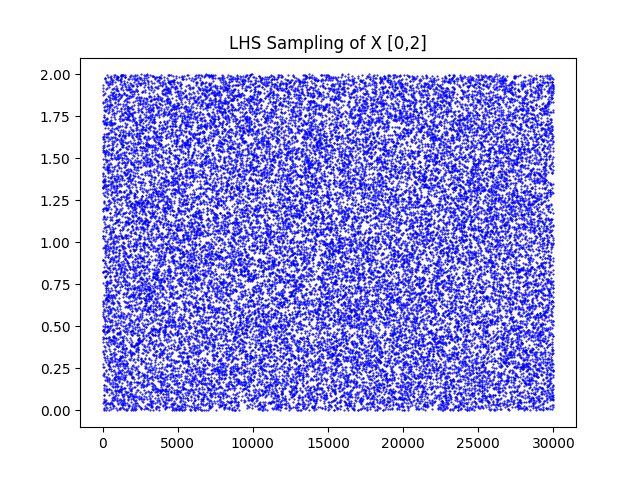

In [33]:
plt.plot(pd.DataFrame(X_train_lhs)[0], "bo", markersize=.5)
plt.title("LHS Sampling of X [0,2]")
plt.show()

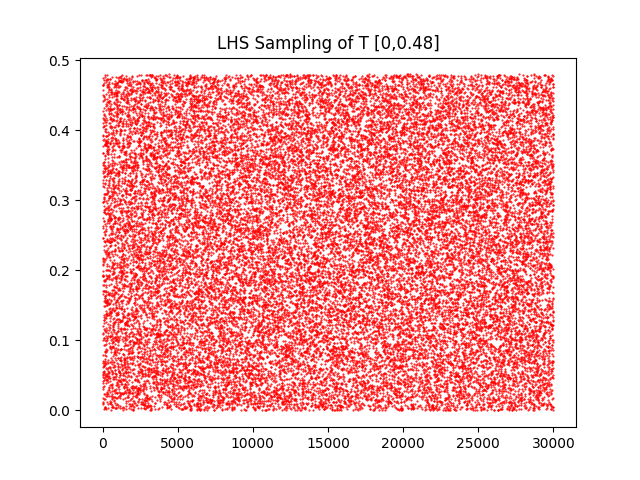

In [34]:
plt.plot(pd.DataFrame(X_train_lhs)[1], "ro", markersize=.5)
plt.title("LHS Sampling of T [0,0.48]")
plt.show()

In [35]:
X_train_final = torch.vstack((X_train_lhs, X_ic_samples, X_bc_samples))
X_train_final.shape

torch.Size([32000, 2])

In [36]:
#Lets define a u_NN

class u_NN(nn.Module):

    def __init__(self, layers_list):

        super().__init__()

        self.depth = len(layers_list)

        self.loss_function = nn.MSELoss(reduction="mean")

        self.activation = nn.Tanh() #This is important, ReLU wont work

        self.linears = nn.ModuleList([nn.Linear(layers_list[i],layers_list[i+1]) for i in range(self.depth-1)])

        for i in range(self.depth-1):

          nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0) #xavier normalization of weights

          nn.init.zeros_(self.linears[i].bias.data) #all biases set to zero

    def Convert(self, x): #helper function

        if torch.is_tensor(x) !=True:
            x = torch.from_numpy(x)
        return x.float().to(device)

    def forward(self, x):

        a = self.Convert(x)

        for i in range(self.depth-2):
            z = self.linears[i](a)
            a = self.activation(z)

        a = self.linears[-1](a)

        return a

    def loss_bc(self, x_bc, u_bc):
        #This is similar to a Supervised Learning

        l_bc = self.loss_function(self.forward(self.Convert(x_bc)), self.Convert(u_bc)) #L2 loss

        return l_bc

    def loss_ic(self, x_ic, u_ic):
        #This is similar to a Supervised Learning

        l_ic = self.loss_function(self.forward(self.Convert(x_ic)), self.Convert(u_ic)) #L2 loss

        return l_ic

    def loss_pde(self, x_pde):
        # We will pass x_train_final here.
        # Note that we do not have U_pde (labels) here to calculate loss. This is not Supervised Learning.
        # Here we want to minimize the residues. So, we will first calculate the residue and then minimize it to be close to zero.

        x_pde = self.Convert(x_pde)

        x_pde_clone = x_pde.clone() ##VERY IMPORTANT

        x_pde_clone.requires_grad = True #enable Auto Differentiation

        NN = self.forward(x_pde_clone) #Generates predictions from u_NN

        NNx_NNt = torch.autograd.grad(NN, x_pde_clone,self.Convert(torch.ones([x_pde_clone.shape[0],1])),retain_graph=True, create_graph=True)[0] #Jacobian of dx and dt

        NNxx_NNtt = torch.autograd.grad(NNx_NNt,x_pde_clone, self.Convert(torch.ones(x_pde_clone.shape)), create_graph=True)[0] #Jacobian of dx2, dt2

        NNxx = NNxx_NNtt[:,[0]] #Extract only dx2 terms

        NNt = NNx_NNt[:,[1]] #Extract only dt terms

        # {(du/dt) = viscosity * (d2u/dx2)} is the pde and the NN residue will be {du_NN/dt - viscosity*(d2u_NN)/dx2} which is == {NNt - viscosity*NNxx}

        residue = NNt - (alpha)*NNxx

        # The residues need to be zero (or as low as possible). We'll create an arrazy of Zeros and minimize the residue

        zeros = self.Convert(torch.zeros(residue.shape[0],1))

        l_pde = self.loss_function(residue, zeros) #L2 Loss

        return l_pde

    def total_loss(self, x_ic, u_ic, x_bc, u_bc, x_pde): #Combine both loss
        l_bc = self.loss_bc(x_bc, u_bc)
        l_ic = self.loss_ic(x_ic, u_ic)
        l_pde = self.loss_pde(x_pde)
        return l_bc + l_pde + l_ic #this HAS to be a scalar value for auto differentiation to do its thing.


In [37]:
#Parameters for u_NN

EPOCHS = 10000
initial_lr = 0.001
layers_list = [2, 32, 128, 16, 128, 32, 1]
#batch_size = 32

# Instantiate a model

PINN = u_NN(layers_list).to(device)
print(PINN)

optimizer = torch.optim.Adam(PINN.parameters(), lr=initial_lr,amsgrad=False)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.985)

history = pd.DataFrame(columns=["Epochs","Learning_Rate", "IC_Loss","BC_Loss","PDE_Loss","Total_Loss","Test_Loss"])


u_NN(
  (loss_function): MSELoss()
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [38]:
#****** Training ******#

print("Training Physics Informed Neural Network...")

Epoch = []
Learning_Rate = []
IC_Loss = []
BC_Loss = []
PDE_Loss = []
Total_Loss = []
Test_Loss = []

for i in tqdm_notebook(range(EPOCHS)):
    if i==0:
        print("Epoch \t Learning_Rate \t IC_Loss \t BC_Loss \t PDE_Loss \t Total_Loss \t Test_Loss")

    l_ic = PINN.loss_ic(X_ic_samples,U_ic_samples)
    l_bc = PINN.loss_bc(X_bc_samples,U_bc_samples)
    l_pde = PINN.loss_pde(X_train_final)
    loss = PINN.total_loss(X_ic_samples,U_ic_samples,X_bc_samples,U_bc_samples, X_train_final)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if i%100 == 0: #print losses and step the exponential learning rate.

        with torch.no_grad():
            test_loss = PINN.loss_bc(x_test,u_test) #Here we are using loss_bc method as a helper function to calculate L2 loss

            Epoch.append(i)
            Learning_Rate.append(scheduler.get_last_lr()[0])
            IC_Loss.append(l_ic.detach().cpu().numpy())
            BC_Loss.append(l_bc.detach().cpu().numpy())
            PDE_Loss.append(l_pde.detach().cpu().numpy())
            Total_Loss.append(loss.detach().cpu().numpy())
            Test_Loss.append(test_loss.detach().cpu().numpy())

            if i%1000 ==0:
               print(i,'\t',format(scheduler.get_last_lr()[0],".4E"),'\t',format(l_ic.detach().cpu().numpy(),".4E"),'\t',format(l_bc.detach().cpu().numpy(),".4E"),'\t',
                  format(l_pde.detach().cpu().numpy(),".4E"),'\t',format(loss.detach().cpu().numpy(),".4E"),'\t',format(test_loss.detach().cpu().numpy(),".4E"))

        scheduler.step()

print("Completed!!")

Training Physics Informed Neural Network...


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 	 Learning_Rate 	 IC_Loss 	 BC_Loss 	 PDE_Loss 	 Total_Loss 	 Test_Loss


/home/floly/anaconda3/envs/fs/lib/python3.11/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0 	 1.0000E-03 	 5.7712E-01 	 2.9688E-02 	 2.9844E-02 	 6.3665E-01 	 4.8724E-01
1000 	 8.5973E-04 	 5.2107E-05 	 4.9171E-06 	 5.7233E-05 	 1.1426E-04 	 4.8708E-05
2000 	 7.3914E-04 	 1.5285E-03 	 2.7642E-03 	 2.8963E-05 	 4.3217E-03 	 1.4241E-03
3000 	 6.3546E-04 	 5.8589E-05 	 4.5792E-05 	 1.7574E-05 	 1.2196E-04 	 1.6294E-04
4000 	 5.4632E-04 	 3.9251E-06 	 4.2725E-07 	 1.2862E-05 	 1.7214E-05 	 3.1599E-06
5000 	 4.6969E-04 	 1.0525E-05 	 1.2241E-05 	 9.9956E-06 	 3.2762E-05 	 7.8051E-06
6000 	 4.0381E-04 	 2.2603E-06 	 2.5029E-07 	 7.9798E-06 	 1.0490E-05 	 1.9435E-06
7000 	 3.4717E-04 	 1.8468E-06 	 2.4919E-07 	 6.6003E-06 	 8.6963E-06 	 1.6332E-06
8000 	 2.9847E-04 	 1.3890E-06 	 1.7145E-07 	 5.5103E-06 	 7.0708E-06 	 1.1912E-06
9000 	 2.5660E-04 	 1.1633E-06 	 4.6823E-07 	 4.7059E-06 	 6.3374E-06 	 1.0692E-06
Completed!!


In [39]:
u_NN_predict = PINN(x_test)

In [40]:
#Reshapping y1 to be used in plot3d()

u_NN_2D = u_NN_predict.reshape(shape=[total_points_t,total_points_x]).transpose(1,0).detach().cpu()

assert u_NN_2D.shape == torch.Size([total_points_x, total_points_t]),f"Expected [{total_points_x},{total_points_t}], got {u_NN_2D.shape}"

In [41]:
RMSE = torch.sqrt(torch.mean(torch.square(torch.subtract(u_NN_2D,u_fdm_2D))))

print("The RMSE error between FDM and PINN is :",np.around(RMSE.item(),5))

The RMSE error between FDM and PINN is : 0.00089


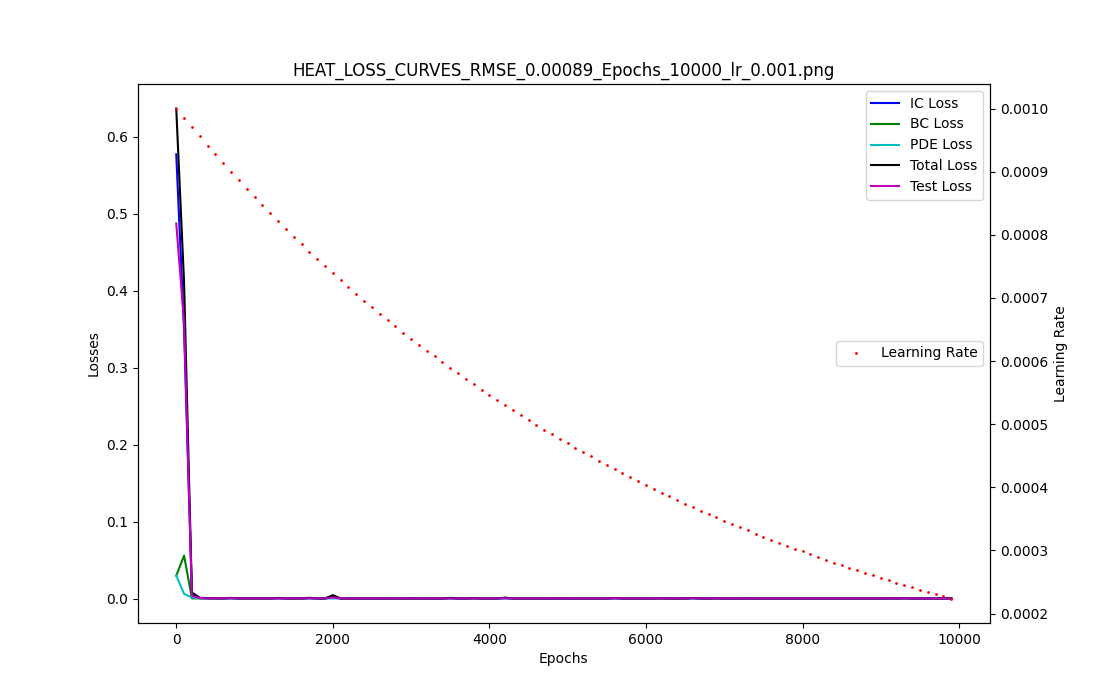

In [42]:
file_name_loss = "HEAT_LOSS_CURVES_RMSE_"+str(np.around(RMSE.item(),5))+"_Epochs_"+str(EPOCHS)+"_lr_"+str(initial_lr)+".png"
fig, ax1 = plt.subplots(figsize=(11, 7), dpi= 100)
ax2 = ax1.twinx()
ax1.plot(Epoch, IC_Loss, "b-",label = "IC Loss")
ax1.plot(Epoch, BC_Loss, "g-",label = "BC Loss")
ax1.plot(Epoch, PDE_Loss, "c-",label = "PDE Loss")
ax1.plot(Epoch, Total_Loss, "k-",label = "Total Loss")
ax1.plot(Epoch, Test_Loss, "m-",label = "Test Loss")
ax2.plot(Epoch,Learning_Rate, "ro",markersize=1,label = "Learning Rate")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Losses', color='k')
ax2.set_ylabel('Learning Rate', color='k')
ax2.legend(loc=7)
ax1.legend(loc=1)
plt.title(file_name_loss)
#plt.show()
plt.savefig(file_name_loss)


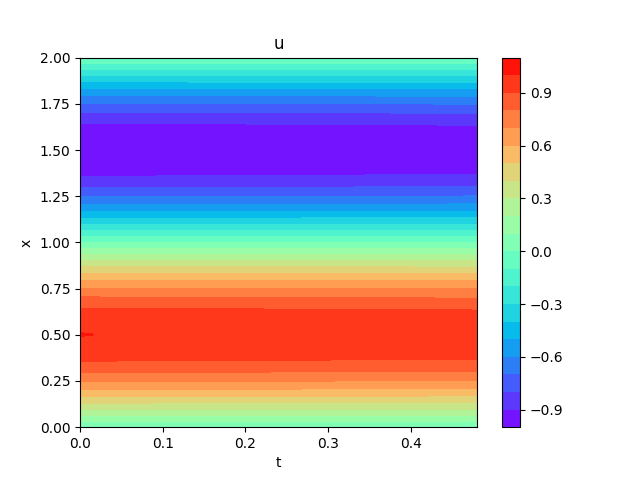

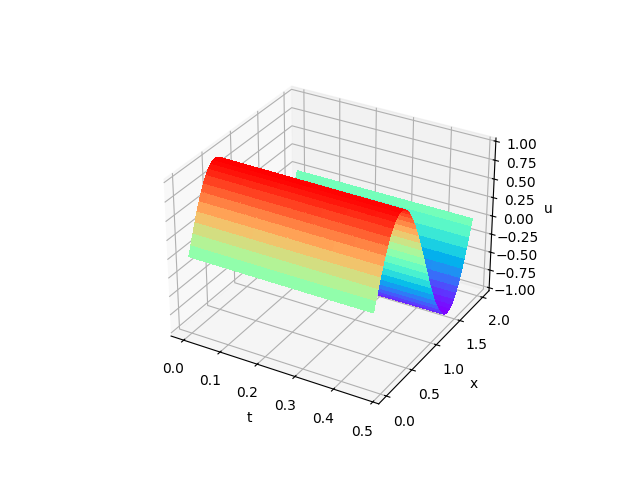

In [43]:
plot3D(x,t,u_NN_2D)

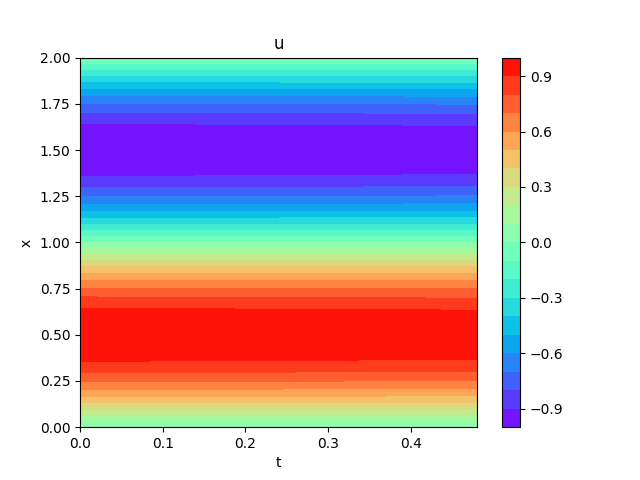

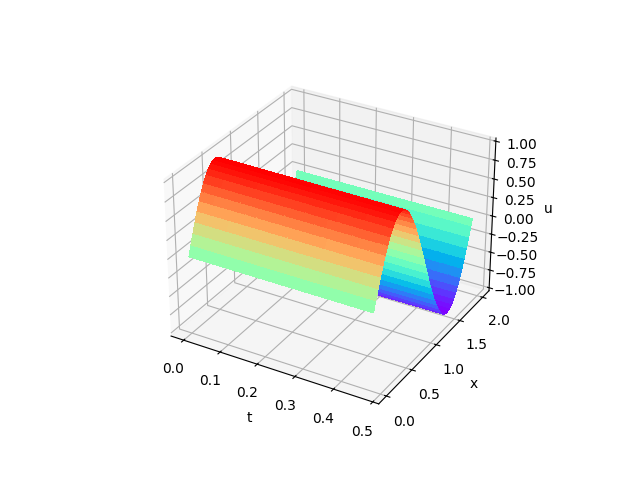

In [44]:
plot3D(x,t,u_fdm_2D)

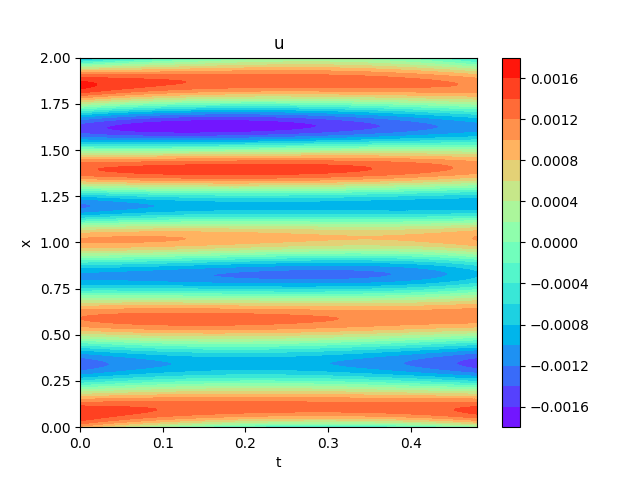

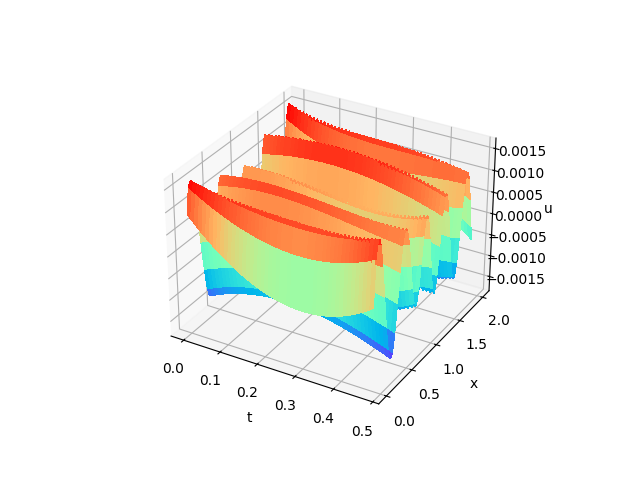

In [45]:
plot3D(x,t,(u_NN_2D - u_fdm_2D)) #Error

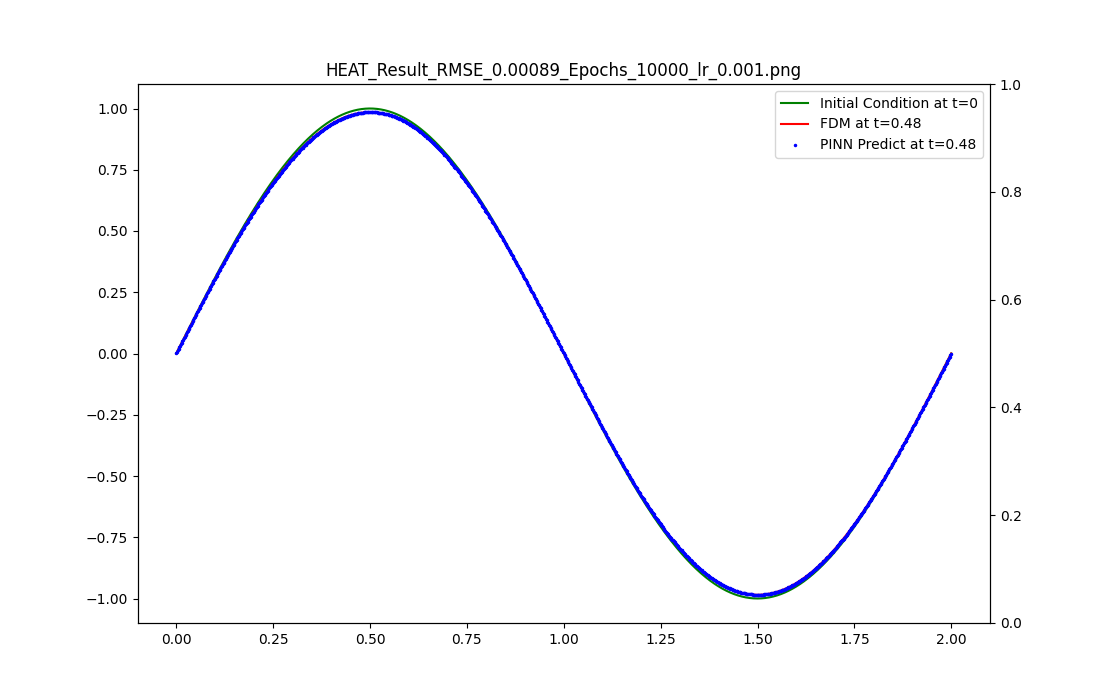

In [46]:
file_name_result = "HEAT_Result_RMSE_"+str(np.around(RMSE.item(),5))+"_Epochs_"+str(EPOCHS)+"_lr_"+str(initial_lr)+".png"

last_U_NN = u_NN_2D[:,-1].unsqueeze(1) #Extracting the last U values at t=0.48

fig, ax1 = plt.subplots(figsize=(11, 7), dpi= 100)
ax2 = ax1.twinx()

ax1.plot(x, u_plot, "g",label="Initial Condition at t=0")
ax1.plot(x, u_final, "r",label="FDM at t=0.48", )
ax1.plot(x, last_U_NN.detach().cpu().numpy(), "bo",label="PINN Predict at t=0.48", markersize=1.5)
ax1.legend()
plt.title(file_name_result)
plt.savefig(file_name_result)


In [47]:
#Saving the model

file_name_model = "HEAT_Result_RMSE_"+str(np.around(RMSE.item(),5))+"_Epochs_"+str(EPOCHS)+"_lr_"+str(initial_lr)+".pth"
torch.save(PINN, file_name_model)


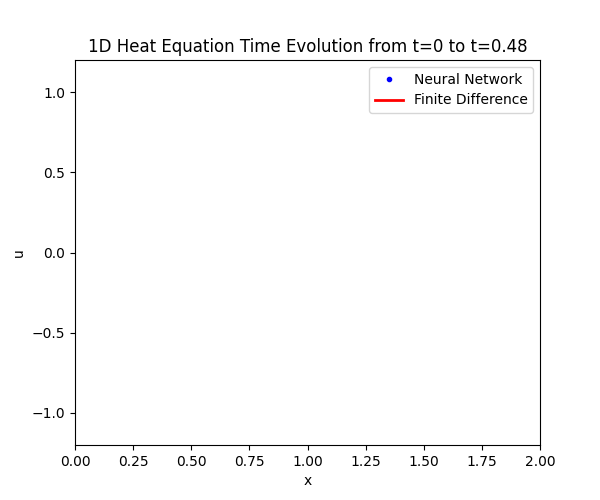

In [48]:
#Imports for animation and display within a jupyter notebook
from matplotlib import animation, rc
from IPython.display import HTML

#Generating the figure that will contain the animation
fig, ax = plt.subplots()
fig.set_dpi(100)
fig.set_size_inches(6, 5)
ax.set_xlim(( x_min, x_max))
ax.set_ylim((-1.2, 1.2))
PINN, = ax.plot([], [], "bo", markersize=3,label='Neural Network')
FDM, = ax.plot([], [], "r", lw=2,label='Finite Difference')
ax.legend();
plt.xlabel('x')
plt.ylabel('u')
plt.title('1D Heat Equation Time Evolution from t=0 to t=0.48');


In [49]:
#Initialization function for funcanimation
def init():
    FDM.set_data([], [])
    PINN.set_data([], [])
    return (PINN, FDM)

In [50]:
#Main animation function, each frame represents a time step in our calculation
def animate(j):

    unn = u_NN_2D[:,j].unsqueeze(1).detach().cpu().numpy()

    ufdm = u_fdm_2D[:,j].unsqueeze(1).detach().cpu().numpy()

    PINN.set_data(x, unn)
    FDM.set_data(x, ufdm)

    return (PINN, FDM,)


In [51]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=total_points_t, interval=100)

### Veryfication

In [53]:
PINN_model = torch.load("./HEAT_Result_RMSE_0.00089_Epochs_10000_lr_0.001.pth", map_location=device)
print("Model PINN załadowany jako PINN_model")

Model PINN załadowany jako PINN_model


/tmp/ipykernel_73656/1209421824.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  PINN_model = torch.load("./HEAT_Result_RMSE_0.00089_Epochs_10000_lr_0.001.pth", map_locat

In [54]:
# Parametry dla rozszerzonego zakresu czasu
t_max_test = 1.0  # Rozszerzamy do 1.0 (było 0.48)
total_points_t_test = 2083  # Proporcjonalnie więcej punktów

print(f"Zakres treningowy: t ∈ [0, {t_max}]")
print(f"Zakres testowy: t ∈ [0, {t_max_test}]")
print(f"Będziemy testować ekstrapolację dla t ∈ [{t_max}, {t_max_test}]")

Zakres treningowy: t ∈ [0, 0.48]
Zakres testowy: t ∈ [0, 1.0]
Będziemy testować ekstrapolację dla t ∈ [0.48, 1.0]


In [55]:
def u_fdm(x,t):
    un = torch.ones(total_points_x)
    rec = torch.zeros([total_points_x, total_points_t])

    for j in tqdm_notebook(range(total_points_t)):

        un = u.clone()

        for i in range(1,total_points_x-1):
            rec[i,j] = u[i]
            u[i] = un[i] + alpha * (dt/dx**2) * (un[i+1]- 2*un[i] + un[i-1])
            if np.isnan(u[i]):
              print(i, j, u[i-1])
              break

    return u, rec

In [56]:
# Rozwiązanie FDM dla rozszerzonego zakresu czasu
def u_fdm_extended(x, t, total_points_x, total_points_t, t_max):
    dx = (x_max - x_min) / (total_points_x - 1)
    dt = (t_max - t_min) / total_points_t
    
    u = torch.from_numpy(np.sin(np.pi * x.squeeze().numpy()))
    un = torch.ones(total_points_x)
    rec = torch.zeros([total_points_x, total_points_t])
    
    print(f"Uruchamianie FDM dla t ∈ [0, {t_max}]...")
    for j in range(total_points_t):
        un = u.clone()
        for i in range(1, total_points_x - 1):
            rec[i, j] = u[i]
            u[i] = un[i] + alpha * (dt/dx**2) * (un[i+1] - 2*un[i] + un[i-1])
            if np.isnan(u[i]):
                print(f"NaN wykryty w i={i}, j={j}")
                break
    
    return u, rec

# Uruchom FDM dla rozszerzonego zakresu
x_extended = torch.linspace(x_min, x_max, total_points_x).view(-1, 1)
t_extended = torch.linspace(t_min, t_max_test, total_points_t_test).view(-1, 1)

u_final_fdm_ext, u_fdm_2D_extended = u_fdm_extended(x_extended, t_extended, total_points_x, total_points_t_test, t_max_test)

print(f"Kształt rozwiązania FDM: {u_fdm_2D_extended.shape}")

Uruchamianie FDM dla t ∈ [0, 1.0]...


/tmp/ipykernel_73656/2012746597.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  if np.isnan(u[i]):


Kształt rozwiązania FDM: torch.Size([1001, 2083])


In [57]:
# Przygotuj dane dla PINN
X_ext, T_ext = torch.meshgrid(x_extended.squeeze(1), t_extended.squeeze(1), indexing='ij')

x_test_extended = torch.hstack((X_ext.transpose(1, 0).flatten()[:, None],
                                T_ext.transpose(1, 0).flatten()[:, None]))

print(f"Kształt danych testowych: {x_test_extended.shape}")

Kształt danych testowych: torch.Size([2085083, 2])


In [ ]:
# Predykcje PINN dla rozszerzonego zakresu
print("Generowanie predykcji PINN dla rozszerzonego zakresu czasu...")
with torch.no_grad():
    u_NN_predict_ext = PINN_model(x_test_extended)

u_NN_2D_ext = u_NN_predict_ext.reshape(shape=[total_points_t_test, total_points_x]).transpose(1, 0).detach().cpu()

print(f"Kształt predykcji PINN: {u_NN_2D_ext.shape}")

Generowanie predykcji PINN dla rozszerzonego zakresu czasu...
Kształt predykcji PINN: torch.Size([1001, 2083])


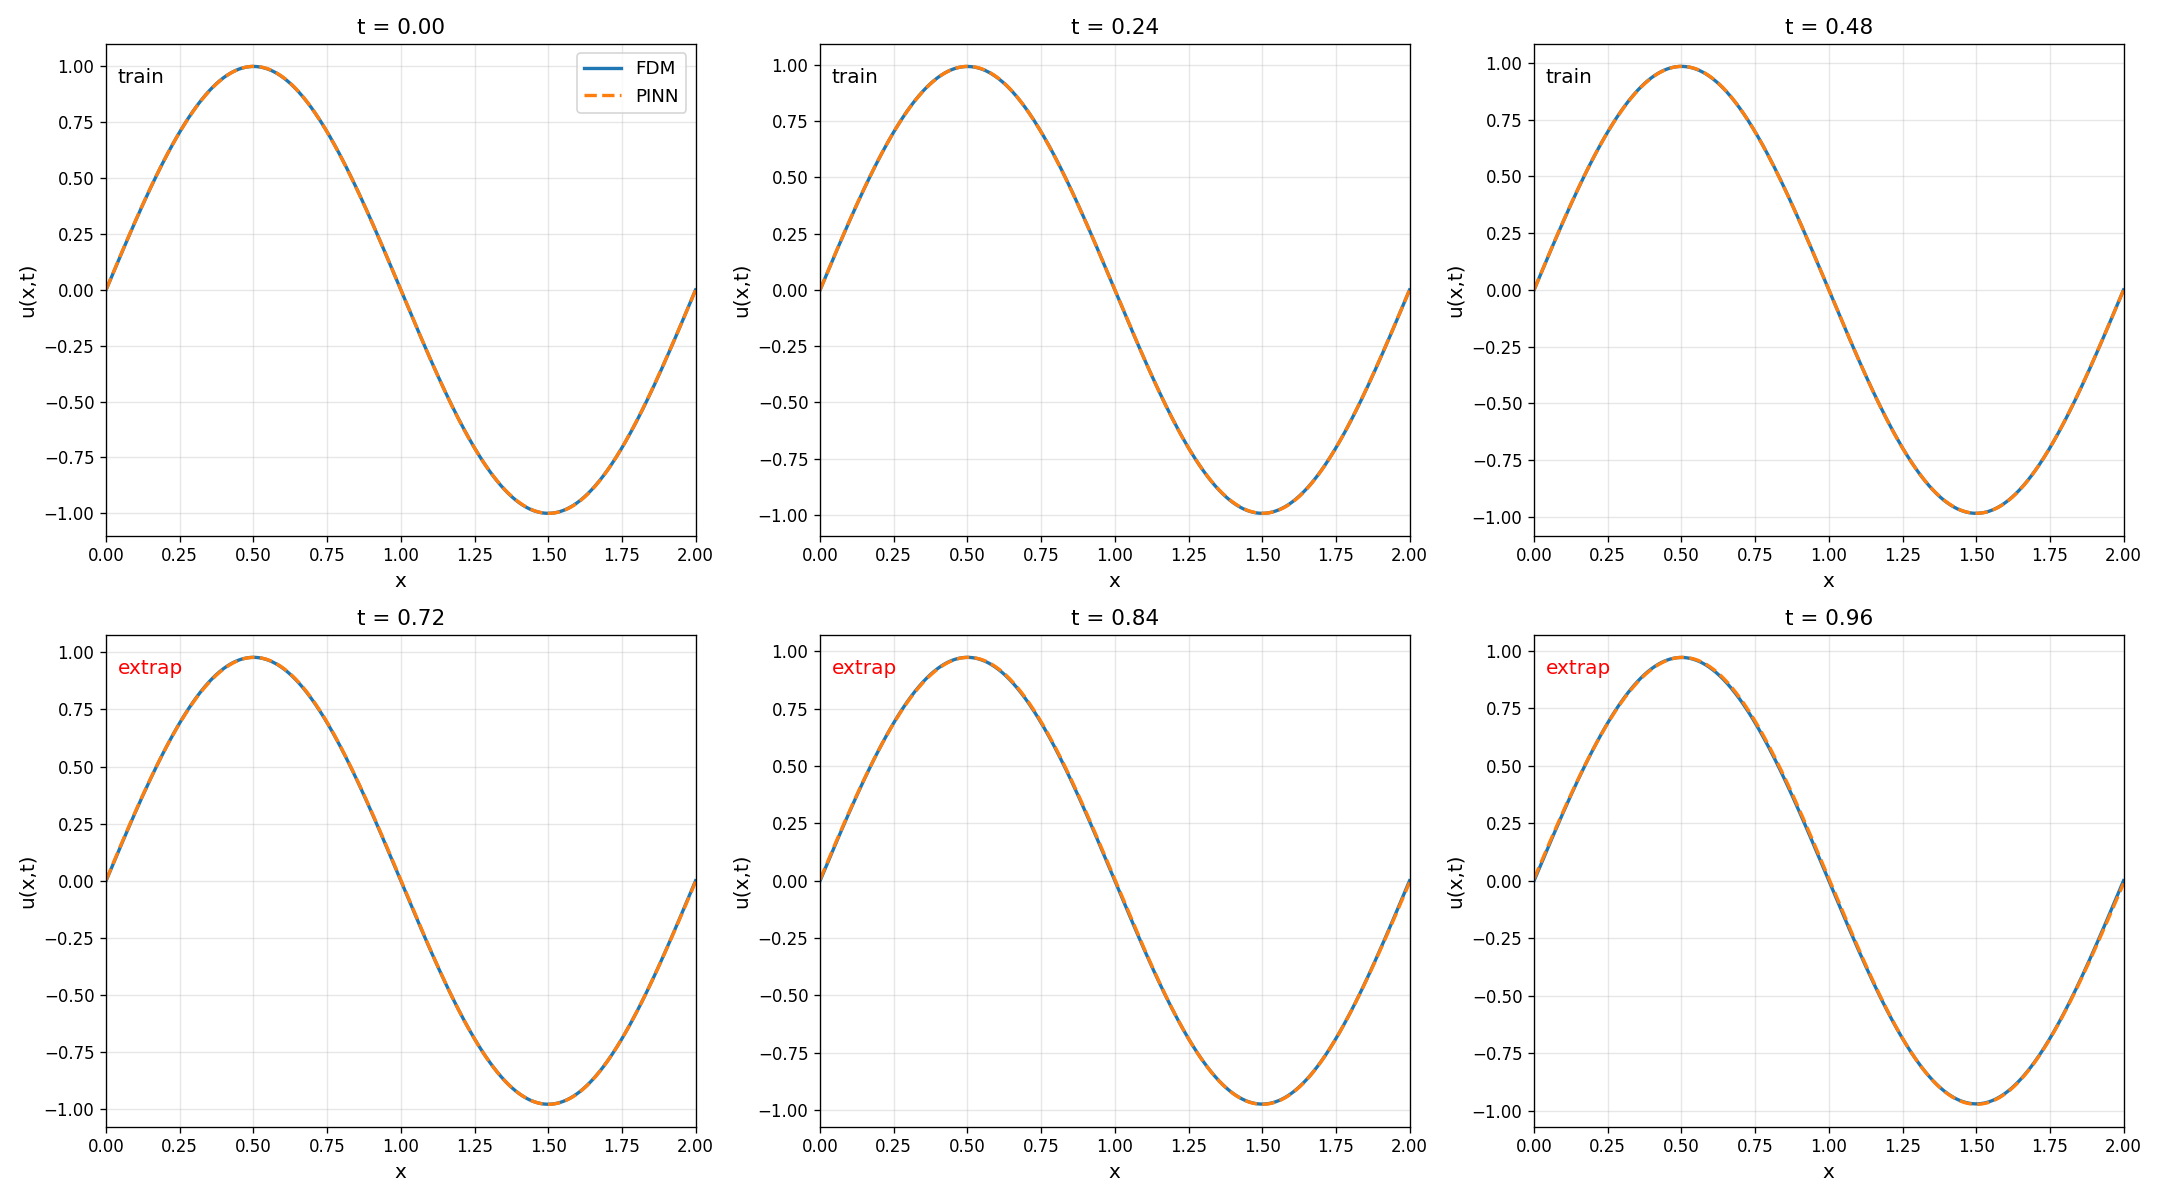

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import torch

x_plot = x_extended.squeeze().detach().cpu().numpy()
t_vals = t_extended.squeeze().detach().cpu().numpy()

# czasy do pokazania (możesz zmienić)
time_snapshots = [0.0, 0.24, 0.48, 0.72, 0.84, 0.96]
time_indices = [np.argmin(np.abs(t_vals - tt)) for tt in time_snapshots]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), dpi=120)
axes = axes.flatten()

for k, (tt, tidx) in enumerate(zip(time_snapshots, time_indices)):
    ax = axes[k]
    ax.plot(x_plot, u_fdm_2D_extended[:, tidx].detach().cpu().numpy(), lw=2, label="FDM")
    ax.plot(x_plot, u_NN_2D_ext[:, tidx].detach().cpu().numpy(), lw=2, linestyle="--", label="PINN")
    
    ax.set_title(f"t = {t_vals[tidx]:.2f}", fontsize=13)
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("u(x,t)", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([x_min, x_max])

    if tt <= t_max:
        ax.text(0.02, 0.92, "train", transform=ax.transAxes, fontsize=12)
    else:
        ax.text(0.02, 0.92, "extrap", transform=ax.transAxes, fontsize=12, color="red")

    if k == 0:
        ax.legend(fontsize=11)

plt.tight_layout()
plt.show()


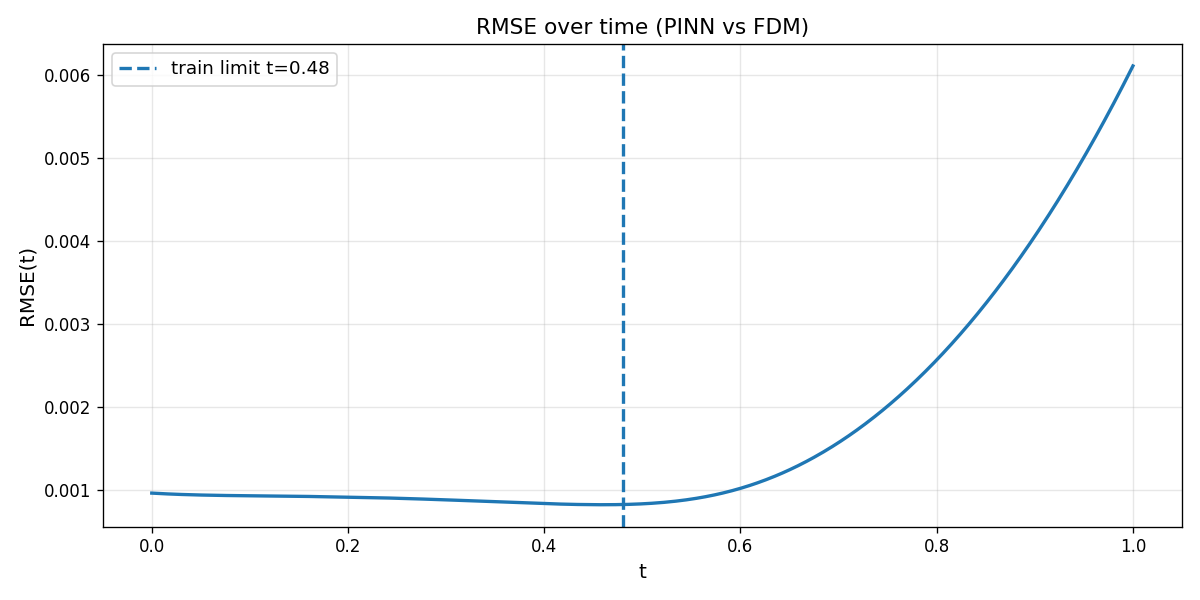

In [68]:
err = (u_NN_2D_ext - u_fdm_2D_extended)
rmse_t = torch.sqrt(torch.mean(err**2, dim=0)).detach().cpu().numpy()

plt.figure(figsize=(10,5), dpi=120)
plt.plot(t_vals, rmse_t, lw=2)
plt.axvline(t_max, linestyle="--", lw=2, label=f"train limit t={t_max}")
plt.xlabel("t", fontsize=12)
plt.ylabel("RMSE(t)", fontsize=12)
plt.title("RMSE over time (PINN vs FDM)", fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


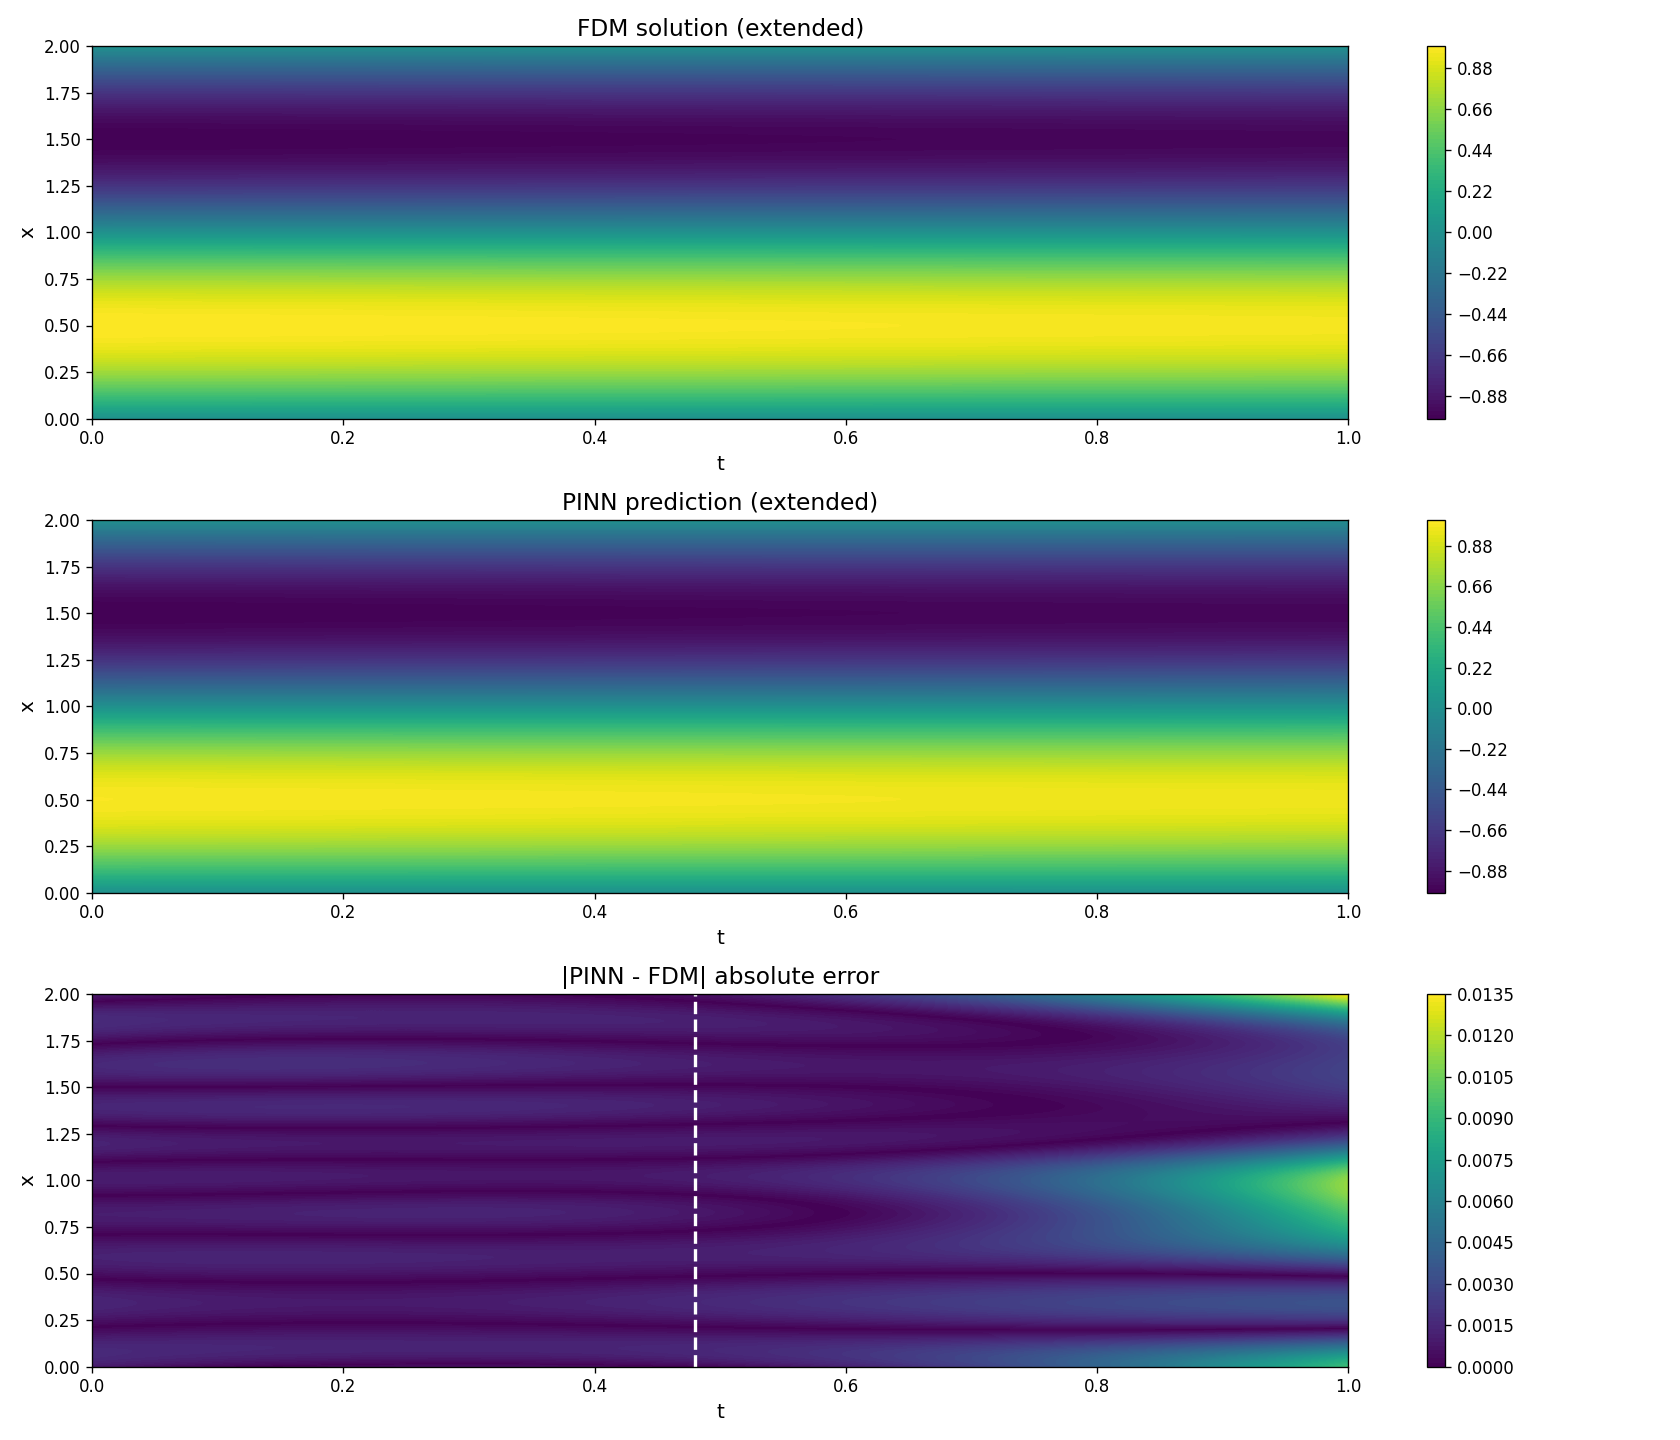

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# osie
x_vals = x_extended.squeeze().detach().cpu().numpy()
t_vals = t_extended.squeeze().detach().cpu().numpy()

# dane
U_fdm  = u_fdm_2D_extended.detach().cpu().numpy()
U_pinn = u_NN_2D_ext.detach().cpu().numpy()
U_err  = np.abs(U_pinn - U_fdm)

fig, axes = plt.subplots(3, 1, figsize=(14, 12), dpi=120)

# --- FDM ---
im0 = axes[0].contourf(t_vals, x_vals, U_fdm, levels=120)
axes[0].set_title("FDM solution (extended)", fontsize=14)
axes[0].set_xlabel("t", fontsize=12)
axes[0].set_ylabel("x", fontsize=12)
fig.colorbar(im0, ax=axes[0])

# --- PINN ---
im1 = axes[1].contourf(t_vals, x_vals, U_pinn, levels=120)
axes[1].set_title("PINN prediction (extended)", fontsize=14)
axes[1].set_xlabel("t", fontsize=12)
axes[1].set_ylabel("x", fontsize=12)
fig.colorbar(im1, ax=axes[1])

# --- ERROR ---
im2 = axes[2].contourf(t_vals, x_vals, U_err, levels=120)
axes[2].set_title("|PINN - FDM| absolute error", fontsize=14)
axes[2].set_xlabel("t", fontsize=12)
axes[2].set_ylabel("x", fontsize=12)
axes[2].axvline(t_max, color="white", linestyle="--", lw=2)  # granica treningu
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()
